## FOOOF on RCS streaming sessions
Inputs

power spectra outputted from MATLAB per RCS streaming channel

* (leveraging the 'Analysis-rcs-data' toolbox (Sellers et al., 2021 *Front. Hum. Neurosci.*)
* prioritzing a similar onboard RCS power calculation

Goals

Use Fitting Oscillations One and Over F (FOOOF) algorithm to identify band peaks and aperiodic contributions in order to:
* remove aperiodic contributions of 
* see stability of band peak frequency over first month of Stage 1
* leverage aperiodic offset and exponent as plausible representations of the lead settling over the first month
    * before stim is turned on so stim-related transient/lasting spectra effects are NOT confounding (besides lasting stage 0 changes)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import time
import sys
import os
from scipy import stats
import shutil

# FOOOF objects and functions
from fooof import FOOOFGroup, FOOOF
from fooof.bands import Bands
from fooof.plts.spectra import plot_spectrum
from fooof.plts.annotate import plot_annotated_model
from fooof.analysis import get_band_peak_fm, get_band_peak_fg


# RBL functions
from  import_FT_RCS_spectra import import_FT_RCS_spectra
from  RBL_fooof_fxns import  plt_save_fooof_analysis

In [2]:
### RBL inputs into general FOOOF approach below:
dirs = {'raw':       '/Volumes/DBS Pain 3/rcs_device_data/processed/spectra_per_sess/',
        'proc':      '/Users/Leriche/pia_server/datastore_spirit/human/rcs_chronic_pain/rcs_device_data/ephy_analysis/spectra_per_sess/',
        'raw_sub':   '/stage1_only (pp work up)/30s_pre_survey/',
        'proc_sub':  '/stage1_only (pp work up)/30s_pre_survey/fooofed'}


sense_homologs   = pd.read_excel(dirs['raw'] + 'rcs_sensing_channels_per_hemisphere.xlsx')
print(sense_homologs)

        RCS02R     RCS04R     RCS04L      RCS05R      RCS05L      RCS06R  \
0  RThal +10-8  RACC +3-0  LACC +3-0  RIFG +10-8  LACC +11-8  RSFG +10-8   
1         none  RACC +3-1  LACC +3-1  RIFG +11-9  LACC +11-9  RSFG +11-9   

        RCS06L      RCS07R      RCS07L  
0  LCaud +10-8  RSGC +10-8  LSGC +10-8  
1  LCaud +11-9  RSGC +11-9  LSGC +11-9  


In [3]:
### RBL inputs into general FOOOF approach below:
fooof_param = pd.DataFrame

fooof_param.freq_range = [2, 40] 

fooof_param.err_thresh = 0.1

## FOOOF alogirthim parameters (directly feed into FOOOF object)
fooof_param.peak_width_limits   = [2.0, 5.0]      # narrowest to widest possible peak width
fooof_param.max_n_peaks         = 4               # max number of peaks to fit
fooof_param.min_peak_height     = 0.1             # min power (db) ABOVE flattened spectrum to be considered a peak
fooof_param.peak_threshold      = 2               # min std(s) above flattened spectrum to be considered a peak
fooof_param.aperiodic_mode      ='knee'           # 'fixed' = 1/(f^x), but 'knee' = 1/(k + f^x)--the latter allows an inflection point in the aperiodic fit

In [4]:
### RBL inputs for analyzing periodic activity
# Define frequency bands of interest
bands = Bands({'theta' : [3, 7],
               'alpha' : [8, 12],
               'low_beta' : [13, 20],
               'high_beta': [20, 35]})

### from FOOF analysis plot/save ACROSS sessions:

* aperiodic fit
    * use RBL's 'plt_save_aperiodic_overtime.py' to analyze longitudinal aperiodic fit changes
     
* relative power spectra (the power spectrum - aperiodic fit)

* fooof parameters
    * aperiodic exponent, and offset
    * periodic center frequecy(ies), power peaks(s), band width(s)
    * model error and r^2
    
* Spearman's correlation of time, aperiodic offset, and exponent



In [5]:
def setup_fooof_dirs(pt_hemi, dirs):
    # make nested folders for organized outputs
    ### *PREVIOUS RUNS ARE DELETED* FOR TROUBLESHOOTING PURPOSES AND CLARITY
    base_dir   = dirs['proc'] + pt_hemi +'/' + dirs['proc_sub'] + ' (' + fooof_param.aperiodic_mode +')' +'/'

    fooof_dirs= {
                'error':        base_dir + 'error_ge_' + str(fooof_param.err_thresh) + '/',
                'aper_fit':    base_dir + 'aperiodic_fits/',
                'pwr_spectra':  base_dir + 'pwr_spectra (aperiodic_fit_removed)/',
                'aper_long':    base_dir + 'aperiodic_longitudinal/',
                'fooof_spec':   base_dir + 'fooofed_spectra (aperiodic_fit_removed)/',
                'fooof_data':   dirs['raw'] + pt_hemi + dirs['raw_sub']  + 'exported_fooof_data/',
                'base_dir':     base_dir
                }


    for a_dir in fooof_dirs:
        
        tmp_dir = fooof_dirs[a_dir]
        if os.path.exists(tmp_dir):
            shutil.rmtree(tmp_dir)
        if not os.path.exists(tmp_dir):
            os.makedirs(tmp_dir)
            
    return  dirs.update(fooof_dirs)

ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)


/Volumes/DBS Pain 3/rcs_device_data/processed/spectra_per_sess/RCS02R/stage1_only (pp work up)/30s_pre_survey/RCS02R_
(4, 59, 397)
['RACC +2-0', 'RACC +3-1', 'RThal +10-8', 'RThal +11-9']
(397,)


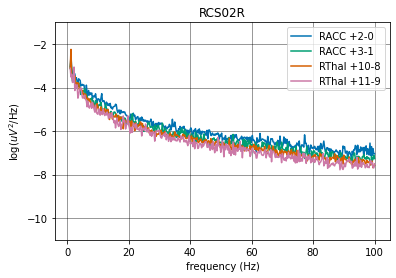

Running FOOOFGroup across 59 power spectra.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)


/Volumes/DBS Pain 3/rcs_device_data/processed/spectra_per_sess/RCS04R/stage1_only (pp work up)/30s_pre_survey/RCS04R_
(4, 115, 397)
['RACC +3-0', 'RACC +3-1', 'RThal +11-8', 'RThal +10-8']
(397,)


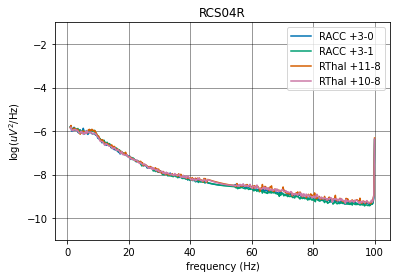

Running FOOOFGroup across 115 power spectra.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


Running FOOOFGroup across 115 power spectra.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)


/Volumes/DBS Pain 3/rcs_device_data/processed/spectra_per_sess/RCS04L/stage1_only (pp work up)/30s_pre_survey/RCS04L_
(4, 117, 397)
['LACC +3-0', 'LACC +3-1', 'LCaud +11-8', 'LCaud +11-9']
(397,)


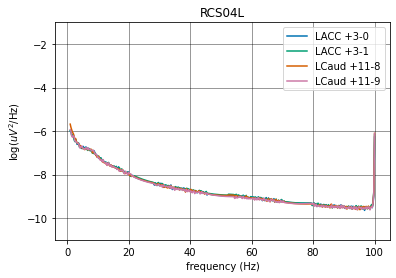

Running FOOOFGroup across 117 power spectra.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


Running FOOOFGroup across 117 power spectra.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)


/Volumes/DBS Pain 3/rcs_device_data/processed/spectra_per_sess/RCS05R/stage1_only (pp work up)/30s_pre_survey/RCS05R_
(4, 74, 397)
['RThal +2-0', 'RThal +3-1', 'RIFG +10-8', 'RIFG +11-9']
(397,)


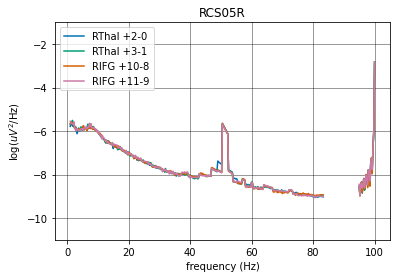

Running FOOOFGroup across 74 power spectra.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


Running FOOOFGroup across 74 power spectra.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)


See:   /Users/Leriche/pia_server/datastore_spirit/human/rcs_chronic_pain/rcs_device_data/ephy_analysis/spectra_per_sess/RCS05R//stage1_only (pp work up)/30s_pre_survey/fooofed (knee)/error_ge_0.1/
for spectra with model error >0.1
/Volumes/DBS Pain 3/rcs_device_data/processed/spectra_per_sess/RCS05L/stage1_only (pp work up)/30s_pre_survey/RCS05L_
(4, 76, 397)
['LCaud +2-0', 'LCaud +2-1', 'LACC +11-8', 'LACC +11-9']
(397,)


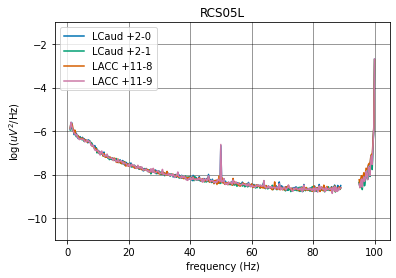

Running FOOOFGroup across 76 power spectra.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


Running FOOOFGroup across 76 power spectra.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)


See:   /Users/Leriche/pia_server/datastore_spirit/human/rcs_chronic_pain/rcs_device_data/ephy_analysis/spectra_per_sess/RCS05L//stage1_only (pp work up)/30s_pre_survey/fooofed (knee)/error_ge_0.1/
for spectra with model error >0.1
/Volumes/DBS Pain 3/rcs_device_data/processed/spectra_per_sess/RCS06R/stage1_only (pp work up)/30s_pre_survey/RCS06R_
(4, 121, 397)
['RThal +2-0', 'RThal +3-1', 'RSFG +10-8', 'RSFG +11-9']
(397,)


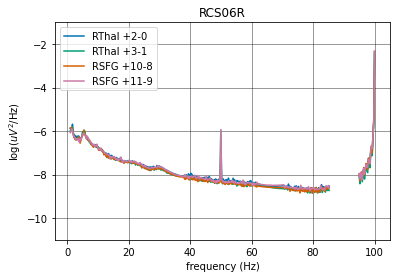

Running FOOOFGroup across 121 power spectra.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


Running FOOOFGroup across 121 power spectra.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)


See:   /Users/Leriche/pia_server/datastore_spirit/human/rcs_chronic_pain/rcs_device_data/ephy_analysis/spectra_per_sess/RCS06R//stage1_only (pp work up)/30s_pre_survey/fooofed (knee)/error_ge_0.1/
for spectra with model error >0.1
/Volumes/DBS Pain 3/rcs_device_data/processed/spectra_per_sess/RCS06L/stage1_only (pp work up)/30s_pre_survey/RCS06L_
(4, 215, 397)
['LACC +2-0', 'LACC +3-1', 'LCaud +10-8', 'LCaud +11-9']
(397,)


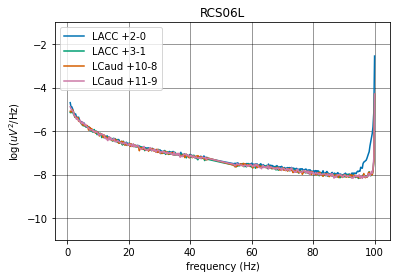

Running FOOOFGroup across 215 power spectra.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


Running FOOOFGroup across 215 power spectra.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)


See:   /Users/Leriche/pia_server/datastore_spirit/human/rcs_chronic_pain/rcs_device_data/ephy_analysis/spectra_per_sess/RCS06L//stage1_only (pp work up)/30s_pre_survey/fooofed (knee)/error_ge_0.1/
for spectra with model error >0.1
/Volumes/DBS Pain 3/rcs_device_data/processed/spectra_per_sess/RCS07L/stage1_only (pp work up)/30s_pre_survey/RCS07L_
(4, 181, 397)
['LGPi +2-0', 'LGPi +3-1', 'LSGC +10-8', 'LSGC +11-9']
(397,)


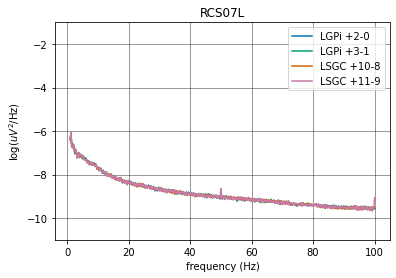

Running FOOOFGroup across 181 power spectra.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


Running FOOOFGroup across 181 power spectra.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)


See:   /Users/Leriche/pia_server/datastore_spirit/human/rcs_chronic_pain/rcs_device_data/ephy_analysis/spectra_per_sess/RCS07L//stage1_only (pp work up)/30s_pre_survey/fooofed (knee)/error_ge_0.1/
for spectra with model error >0.1
/Volumes/DBS Pain 3/rcs_device_data/processed/spectra_per_sess/RCS07R/stage1_only (pp work up)/30s_pre_survey/RCS07R_
(4, 181, 397)
['RThal +2-0', 'RThal +3-1', 'RSGC +10-8', 'RSGC +11-9']
(397,)


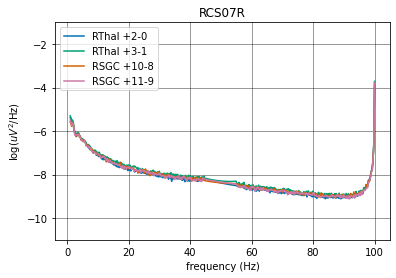

Running FOOOFGroup across 181 power spectra.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


Running FOOOFGroup across 181 power spectra.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


See:   /Users/Leriche/pia_server/datastore_spirit/human/rcs_chronic_pain/rcs_device_data/ephy_analysis/spectra_per_sess/RCS07R//stage1_only (pp work up)/30s_pre_survey/fooofed (knee)/error_ge_0.1/
for spectra with model error >0.1


In [6]:
### main hemisphere and channels for-loops

pt_sides = ['RCS02R', 'RCS04R', 'RCS04L', 'RCS05R', 'RCS05L', 'RCS06R','RCS06L','RCS07L', 'RCS07R']


for i in range(len(pt_sides)):
    
    pwrspectra_by_sess, fft_bins_inHz, ch_names, parsed_db_oi = import_FT_RCS_spectra(pt_sides[i], dirs)
    

    setup_fooof_dirs(pt_sides[i], dirs)
    
    bool_chan       = [any(a_ch == sense_homologs[pt_sides[i]]) for a_ch in ch_names]
    ind_sense_chan  = [i for i, x in enumerate(bool_chan) if x]
    
    t_peri_ephy = parsed_db_oi.timeStart

    for i_ch in ind_sense_chan:
        spectra_oi = pwrspectra_by_sess[i_ch, :, :]
    
        # FOOOF all spectra individually in single run
        fg = FOOOFGroup(
                        peak_width_limits  = fooof_param.peak_width_limits, 
                        max_n_peaks        = fooof_param.max_n_peaks, 
                        min_peak_height    = fooof_param.min_peak_height,
                        peak_threshold     = fooof_param.peak_threshold,
                        aperiodic_mode     = fooof_param.aperiodic_mode)

              # Model the power spectrum with FOOOF
        fg.fit(fft_bins_inHz, spectra_oi, fooof_param.freq_range)

        ### save aperiodic parameters, plot corr(aperiodic, time)
        plt_save_fooof_analysis(pt_sides[i], dirs, ch_names[i_ch],
                                    fooof_param,
                                    t_peri_ephy, fg)

        ### only needed once per loop   
        if i_ch ==3:
            pd.DataFrame(fg.freqs).to_excel(dirs['fooof_data'] + 'fooof_freqs.xlsx', index=False)
            print('See:   ' + dirs['error'] + '\nfor spectra with model error >' +  str(fooof_param.err_thresh))

In [ ]:
for pb in bands:
    power_bands = get_band_peak_fg(fg, bands[pb[0]])
    
    center_frequencies = power_bands[:, 0 ]
    peak_height        = power_bands[:, 1]
    band_width         = power_bands[:, 2]

In [ ]:
plot_annotated_model(fm)

In [ ]:
cln_spectrum_db = avg_wo_aperiodic +  np.mean(aperiodic_comp,0)

In [ ]:
cln_spectrum = np.power(10, cln_spectrum_db)

In [ ]:
# Initialize a FOOOF model object with defined settings
fm = FOOOF(fooof_param.peak_width_limits=[1.0, 5.0], fooof_param.max_n_peaks=5, fooof_param.min_peak_height=0.1,
           fooof_param.peak_threshold=2, fooof_param.aperiodic_mode='fixed')

fooof_param.freq_range = [1, 80]

# Model the power spectrum with FOOOF, and print out a report
fm.fit(fg.freqs, cln_spectrum, fooof_param.freq_range)
fm.plot(plot_peaks='shade', peak_kwargs={'color' : 'green'})

For demonstrative purposes, the fully annotated FOOOF model parameters

In [ ]:
# Plot an annotated version of the power spectrum model
plot_annotated_model(fm)